In [1]:
from cil.optimisation.operators import GradientOperator, SymmetrisedGradientOperator, IdentityOperator, ZeroOperator, BlockOperator
from cil.optimisation.functions import MixedL21Norm, BlockFunction, L2NormSquared, ZeroFunction
from cil.optimisation.algorithms import PDHG
from cil.utilities import dataexample
from cvxpy import *
from regularisers import tgv
import numpy as np
import matplotlib.pyplot as plt
from cil.utilities.display import show2D

# Load Data and resize

In [2]:
data = dataexample.CAMERA.get(size=(32, 32))

# Setup and run tgv denoising with cvxpy

In [3]:
# solution
u_cvx = Variable(data.shape)
w1_cvx = Variable(data.shape)
w2_cvx = Variable(data.shape)

# regularisation parameters
alpha0 = 0.1
alpha1 = 0.3

# fidelity term
fidelity = 0.5 * sum_squares(u_cvx - data.array)   
regulariser = tgv(u_cvx, w1_cvx, w2_cvx, alpha1, alpha0)

# objective
obj =  Minimize( regulariser +  fidelity)
prob = Problem(obj, constraints = [])

# Choose solver ( SCS, MOSEK(license needed) )
tv_cvxpy = prob.solve(verbose = True, solver = SCS)

                                     CVXPY                                     
                                    v1.1.17                                    
(CVXPY) Dec 06 07:53:11 PM: Your problem has 3072 variables, 0 constraints, and 0 parameters.
(CVXPY) Dec 06 07:53:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 06 07:53:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 06 07:53:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 06 07:53:11 PM: Compiling problem (target solver=SCS).
(CVXPY) Dec 06 07:53:11 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

# Setup TGV denoising using CIL and the PDHG algorithm

In [4]:
ig = data.geometry

K11 = GradientOperator(ig)
K22 = SymmetrisedGradientOperator(K11.range)
K12 = IdentityOperator(K11.range)
K21 = ZeroOperator(ig, K22.range)
K = BlockOperator(K11, -K12, K21, K22, shape=(2,2) )

f1 = alpha1 * MixedL21Norm()
f2 = alpha0 * MixedL21Norm()
F = BlockFunction(f1, f2)
G = BlockFunction(0.5 * L2NormSquared(b=data), ZeroFunction())

sigma = 1./np.sqrt(12)
tau = 1./np.sqrt(12)

# Setup and run the PDHG algorithm
pdhg_tgv = PDHG(f=F,g=G,operator=K,
            max_iteration = 1000, sigma=sigma, tau=tau,
            update_objective_interval = 500)
pdhg_tgv.run(verbose = 2)

Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    2.15422e+02  -0.00000e+00    2.15422e+02


/opt/anaconda3/envs/cil_cvxpy/lib/python3.9/site-packages/cil/optimisation/algorithms/PDHG.py:477: UserWarning: Convergence criterion of PDHG for scalar step-sizes is not satisfied.
  warnings.warn("Convergence criterion of PDHG for scalar step-sizes is not satisfied.")
/opt/anaconda3/envs/cil_cvxpy/lib/python3.9/site-packages/cil/framework/framework.py:2421: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      500       1000         0.008    8.48440e+00   8.46977e+00    1.46298e-02
     1000       1000         0.008    8.47692e+00   8.47331e+00    3.61393e-03
----------------------------------------------------------------------------
     1000       1000         0.008    8.47692e+00   8.47331e+00    3.61393e-03
Stop criterion has been reached.



# Compare solutions

CVX objective = 8.476068484702772
CIL objective = 8.476922034844755


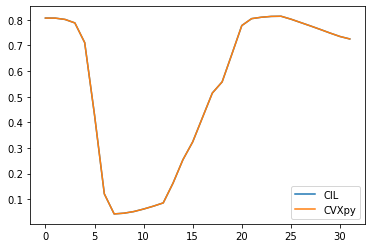

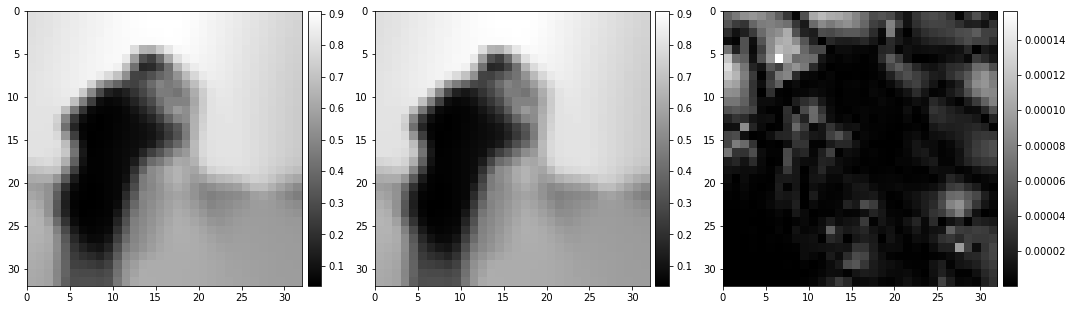

In [5]:
np.testing.assert_almost_equal(pdhg_tgv.solution[0].array, u_cvx.value, decimal=3)

# print objectives
print("CVX objective = {}".format(obj.value))
print("CIL objective = {}".format(pdhg_tgv.objective[-1]))

# show middle line profiles
N, M = data.shape
plt.figure()
plt.plot(pdhg_tgv.solution[0].array[int(N/2)], label="CIL")
plt.plot(u_cvx.value[int(N/2)], label="CVXpy")
plt.legend()
plt.show()

show2D([pdhg_tgv.solution[0].array, u_cvx.value, np.abs(pdhg_tgv.solution[0].array - u_cvx.value)], num_cols = 3, origin="upper")